In [6]:
from google.colab import drive 
drive.mount('/content/myfiles')

Mounted at /content/myfiles


In [7]:
%cd "/content/myfiles/MyDrive/Politechnika/GSN/gsn-2022z-hand-segmentation"
!pwd

/content/myfiles/MyDrive/Politechnika/GSN/gsn-2022z-hand-segmentation
/content/myfiles/MyDrive/Politechnika/GSN/gsn-2022z-hand-segmentation


In [ ]:
!git pull

Already up to date.


In [ ]:
!git status


On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   load_data.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.gitignore

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git add load_data.ipynb

In [ ]:
!git commit -m "add ipynb file for data loading"

[main 675f5a5] add ipynb file for data loading
 1 file changed, 1 insertion(+)
 create mode 100644 load_data.ipynb


In [ ]:
!git push 

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.04 KiB | 265.00 KiB/s, done.
Total 3 (delta 0), reused 0 (delta 0)
To https://gitlab-stud.elka.pw.edu.pl/mmarcin5/gsn-2022z-hand-segmentation.git
   b013726..675f5a5  main -> main


In [8]:
import os
from csv import writer


def append_csv_description(image_dir, label_dir, csv_file):

    with open(csv_file, 'a', newline='\n') as f_object:
        writer_object = writer(f_object)

        for file in os.listdir(image_dir):
            if file.endswith(".jpg"):
                base_name = file[:-4]
                csv_row = [os.path.join(image_dir, file), 
                           os.path.join(label_dir, base_name + ".bmp")]
                writer_object.writerow(csv_row)

        f_object.close()


def get_all_dirs(dir_name):
    sub_dirs = [f.path for f in os.scandir(dir_name) if f.is_dir()]
    return sub_dirs


def create_segmentation_description_file(description_file, image_dir, 
                                          label_dir,
                                          clear=False):
  

      if clear:
          if os.path.exists(description_file):
              print("clearing old content ...")
              os.remove(description_file)

      f = open(description_file, 'a', newline='')
      w = writer(f)
      if clear:
          w.writerow(["image_name", "label_name"])
      f.close()
      append_csv_description(image_dir, label_dir, description_file)
      print("\nfile {} generated".format(description_file))



In [27]:
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_image
from PIL import Image
import torchvision.transforms as transforms
import torch


class SkinDataset(Dataset):
    def __init__(self, description_file, out_size, transform_image=None, 
                 target_transform=None):
        self.images_file = pd.read_csv(description_file)
        self.transform_image = transform_image
        self.target_transform = target_transform
        self.size = out_size
        self.resize = transforms.Resize(self.size)

    def __len__(self):
        return len(self.images_file)

    def __getitem__(self, idx):
        img_path = self.images_file.iloc[idx, 0]
        image = read_image(img_path)
        w = image.size()[1]
        h = image.size()[2]
        if(w > h):
          diff = w - h
          pad = (0, diff, 0, 0)
        else:
          diff = h - w
          pad = (0, 0, 0, diff)
        if self.transform_image:
            image = self.transform_image(image.to(torch.float64))
        image = torch.nn.functional.pad(image, pad, mode='constant', value=1)
        image = self.resize(image)

        label_path = self.images_file.iloc[idx, 1]
        label = Image.open(label_path)
        if self.target_transform:
            label = self.target_transform(label)
        label = torch.nn.functional.pad(label, pad, mode='constant', value=1)
        label = self.resize(label)
        label_one_hot = torch.nn.functional.one_hot(label.to(torch.int64), 2).transpose(1, 3).squeeze().permute(0, 2, 1)


        return image, label_one_hot


In [10]:
create_segmentation_description_file("data_type1.csv", "data/1_original_images", 
                                    "data/1_skin_masks", clear=True)

create_segmentation_description_file("data_type2a.csv", "data/2a_original_images", 
                                    "data/2a_skin_masks", clear=True)

clearing old content ...

file data_type1.csv generated
clearing old content ...

file data_type2a.csv generated


In [28]:

import matplotlib.pyplot as plt
mean = torch.tensor([63.4062, 57.8478, 55.2177], dtype=torch.float64)
std = torch.tensor([52.1825, 46.3412, 44.8947], dtype=torch.float64)

transform_label = transforms.Compose([transforms.ToTensor()])
transform_image = transforms.Compose([transforms.Normalize(mean, std)])

data_1 = SkinDataset("data_type1.csv", 512,  transform_image, transform_label)
data_2 = SkinDataset("data_type2a.csv", 512,  transform_image, transform_label)
data_all = torch.utils.data.ConcatDataset([data_1, data_2])
im, lab = data_all[1]

In [29]:
mean = 0.0
std = 0.0
print(len(data_all))
i = 0
for img, _ in data_all:
    if(i%100==0):
        print(i)
    i = i + 1
    #mean += img.sum([1,2])/torch.numel(img[0])
    mean += torch.mean(img.to(torch.float64), dim=[1, 2])
    std += torch.std(img.to(torch.float64), dim=[1, 2])
mean = mean/len(data_all)
std = std/len(data_all)

print(mean)
print(std)

983
0
100
200
300
400
500
600
700
800
900
tensor([0.5845, 0.5927, 0.5876], dtype=torch.float64)
tensor([0.7053, 0.7164, 0.7535], dtype=torch.float64)


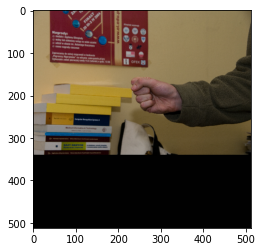

In [162]:
plt.imshow(im.permute(1, 2, 0))

In [163]:
import numpy as np
print(np.shape(lab))
print(np.shape(im))


torch.Size([2, 512, 512])
torch.Size([3, 512, 512])


In [164]:
np.shape(lab[[1]])

torch.Size([1, 512, 512])

torch.Size([512, 512, 2])


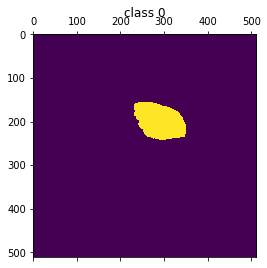

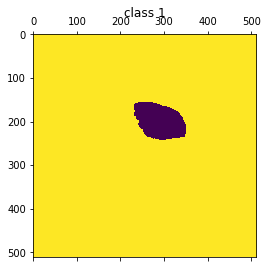

In [165]:
plt.matshow(np.squeeze(lab[[0]].permute(1, 2, 0)))
plt.title("class 0")
plt.matshow(np.squeeze(lab[[1]].permute(1, 2, 0)))
plt.title("class 1")
print(np.shape(np.squeeze(lab.permute(1, 2, 0))))

In [166]:
np.shape(np.squeeze(lab[[1]].permute(1, 2, 0)))

torch.Size([512, 512])

In [157]:
np.array(np.squeeze(lab[[0]].permute(1, 2, 0)))[0][0]

0

## W tej konwencji: żółty -> "1", fioletowy -> "0" to znaczy że klasa "ręka" znajduje się na pierwszej mapie ("lab[[0]]") a klasa tło na drugiej mapie ("lab[[1]]")

In [147]:
im, lab = data_1[0]

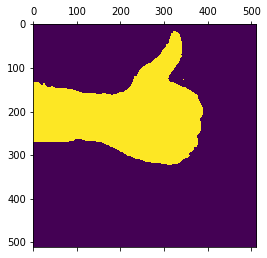

In [148]:
plt.matshow(np.squeeze(lab[[0]].permute(1, 2, 0)))


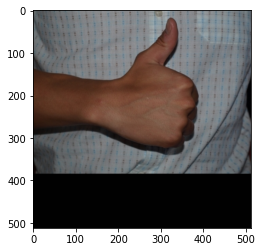

In [98]:
plt.imshow(im.permute(1, 2, 0))

In [ ]:
create_segmentation_description_file("data_type1.csv", "data/1_original_images", 
                                    "data/1_skin_masks", clear=True)

create_segmentation_description_file("data_type2a.csv", "data/2a_original_images", 
                                    "data/2a_skin_masks", clear=True)

create_segmentation_description_file("data_type2b.csv", "data/2b_original_images", 
                                    "data/2b_skin_masks", clear=True)

In [ ]:
mean = torch.tensor([63.4062, 57.8478, 55.2177], dtype=torch.float64)
std = torch.tensor([52.1825, 46.3412, 44.8947], dtype=torch.float64)

transform_label = transforms.Compose([transforms.ToTensor()])
transform_image = transforms.Compose([transforms.Normalize(mean, std)])

data_1 = SkinDataset("data_type1.csv", 512,  transform_image, transform_label)
data_2 = SkinDataset("data_type2a.csv", 512,  transform_image, transform_label)
data_3 = SkinDataset("data_type2b.csv", 512,  transform_image, transform_label)

train_percent = 0.8
train_len_1 = int(np.floor(train_percent*len(data_1)))
train_len_2 = int(np.floor(train_percent*len(data_2)))
train_len_3 = int(np.floor(train_percent*len(data_3)))

train_1, test_1 = torch.utils.data.random_split(data_1, [train_len_1, len(data_1) - train_len_1], generator=torch.Generator().manual_seed(42))
train_2, test_2 = torch.utils.data.random_split(data_2, [train_len_2, len(data_2) - train_len_2], generator=torch.Generator().manual_seed(42))
train_3, test_3 = torch.utils.data.random_split(data_3, [train_len_3, len(data_3) - train_len_3], generator=torch.Generator().manual_seed(42))

data_train_val = torch.utils.data.ConcatDataset([train_1, train_2, train_3])

# get validation dataset
val_percent = 0.15
val_len = int(np.floor(val_percent*len(data_train_val)))
data_train, data_val = torch.utils.data.random_split(data_train_val, 
                                                     [len(data_train_val)-val_len, val_len], 
                                                     generator=torch.Generator().manual_seed(42))

In [34]:
!git commit -m "add "